In [1]:
import os
import re
import sys
import numpy as np
import json
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from IPython.display import HTML, display
from pathlib import Path
from tabulate import tabulate
import sqlite3


In [2]:
def merge_dicts(dict1, dict2)-> dict:
    merged_dict = {}
    for key in dict1.keys():
        merged_dict[key] = [dict1[key], dict2[key]]
    #print(merged_dict)
    return merged_dict


def nni_query(tiral_sqlite_path, show=True) -> dict:

    # Connect to the SQLite database
    connection = sqlite3.connect(tiral_sqlite_path)
    cursor = connection.cursor()

    query = f"""
        SELECT trialjobId, sequence, data
        FROM MetricData
        WHERE trialjobId IN (
            SELECT trialjobId
            FROM MetricData
            WHERE type = 'FINAL'
            GROUP BY trialjobId
            ORDER BY data DESC
            LIMIT 5
        ) 
        AND type = 'PERIODICAL'
        ORDER BY trialjobId, sequence;
    """


    # Execute the query
    cursor.execute(query)

    # Fetch the results
    results = cursor.fetchall()
    print(results)
    score_dict = {}
    if len(results) == 0:
        print('NO METRICS FOUND')
        return
    if "{" not in results[0][2]:
        
        print("found single Score")
        query = """
                UPDATE MetricData
                SET data = replace(data, '"', '');
                """
        
        cursor.execute(query)
        connection.commit()

        query = f"""
                SELECT
                    trialjobId,
                    sequence,
                    CAST(data AS REAL) AS d,
                    MAX(CAST(data AS REAL)) OVER (PARTITION BY trialjobId) AS max_data
                FROM MetricData
                WHERE trialjobId IN (
                    SELECT trialjobId
                    FROM MetricData
                    WHERE type = 'FINAL'
                    GROUP BY trialjobId
                    ORDER BY CAST(data AS REAL) DESC
                    LIMIT 5
                ) AND type = 'PERIODICAL'
                ORDER BY  max_data DESC,trialjobId,sequence;
                """
            # Execute the query
        cursor.execute(query)
        results = cursor.fetchall()

        query = f"""
                UPDATE MetricData
                SET data = '"' || data || '"'
                WHERE data IS NOT NULL;
                """
        cursor.execute(query)
        connection.commit()
    else:
        print("found multiple metrics, tracking only default")
        query = f"""
                UPDATE MetricData
                SET data = replace(data, '\\"', '"');
                """
        cursor.execute(query)
        connection.commit()
        query = f"""
                UPDATE MetricData
                SET data = replace(data, '"{{', '{{');
                """
        cursor.execute(query)
        connection.commit()
        query = f"""
                UPDATE MetricData
                SET data = replace(data, '}}"', '}}');
            """
        
        cursor.execute(query)
        connection.commit()
        query = f"""
                SELECT trialjobId,
                        sequence,
                        CAST(JSON_EXTRACT(data, '$.default') AS REAL) as metrics,
                        MAX(CAST(JSON_EXTRACT(data, '$.default') AS REAL)) OVER (PARTITION BY trialjobId) AS max_data
                FROM MetricData
                WHERE trialjobId IN (
                    SELECT trialjobId
                    FROM MetricData
                    WHERE type = 'FINAL'
                    GROUP BY trialjobId
                    ORDER BY MAX(CAST(JSON_EXTRACT(data, '$.default') AS REAL)) DESC
                    LIMIT 5
                ) 
                AND type = 'PERIODICAL'
                ORDER BY max_data DESC, trialjobId, sequence;
            """
        
        cursor.execute(query)
        results = cursor.fetchall()

        query = f"""
                UPDATE MetricData
                SET data = replace(data, '"', '\\"');
                """
        cursor.execute(query)
        connection.commit()
        query = f"""
                UPDATE MetricData
                SET data = replace(data, '{{', '"{{');
                """
        cursor.execute(query)
        connection.commit()
        query = f"""
                UPDATE MetricData
                SET data = replace(data, '}}', '}}"');
            """
        
        cursor.execute(query)
        connection.commit()
            
                # Execute the query


    # Fetch the results
    #print(results)
    for row in results:
        trialjob_id = row[0]
        sequence = row[1]

    # If trialjob_id is not already in the dictionary, add it with an empty list
        if trialjob_id not in score_dict:
            score_dict[trialjob_id] = []

        # Append the data to the list, maintaining the order by sequence
        score_dict[trialjob_id].append(row[2])
    #print('score dict', score_dict)
    query2 = f"""
            SELECT trialjobId, data
            FROM TrialJobEvent
            WHERE event = 'WAITING'
            AND trialjobId IN ({', '.join('?' for _ in score_dict.keys())});
            """ 
    cursor.execute(query2, list(score_dict.keys()))
    results2 = cursor.fetchall()
    connection.close()

    params_dict = {}
    for row in results2:
        trialjob_id = row[0]
        parameters = json.loads(row[1])
        # If trialjob_id is not already in the dictionary, add it with an empty list
        if trialjob_id not in params_dict:
        # Append the data to the list, maintaining the order by sequence
            params_dict[trialjob_id] = (parameters['parameters'])

    merged_dict = merge_dicts(score_dict, params_dict)  
    
    if show == True:
        
        values = next(iter(merged_dict.values()))
        header = [['Trials Name'] + list(values[1].keys()) + ['Score']]
        plt.figure(figsize=(15, 10))
        
        for key, value in merged_dict.items():
            
            plt.plot(range(len(value[0])), value[0], label=f'{key}, best:{max(value[0]):.4f}')
            rows = [key] + list(value[1].values()) + [max(value[0])]
            header.append(rows)
        plt.legend()
        plt.show()
        
        print(tabulate(header, headers='firstrow', tablefmt='grid'))    

    return merged_dict


def show_results(path, experiment_code=None, print_content=False):

    if os.path.isdir(path):
            # Ottieni la lista di tutti i file e le directory nel path
            if experiment_code is None:
                dir_content = os.listdir(path)
            else:
                dir_content = [experiment_code]
            
            # Scansiona tutti gli elementi nel path
            for element in dir_content:
                print(f'experiment codename {element}')
                db_path = os.path.join(path, element,'db/nni.sqlite')
                if os.path.isfile(db_path):
                    print(db_path)
                    experimet_best_dict = nni_query(db_path, show=True)
                    if experimet_best_dict is not None and print_content == True:
                        for trial in experimet_best_dict.keys(): 
                            loss_trial_path = os.path.join(path, element,'trials', trial, 'Trained/loss.txt')
                            data = np.loadtxt(loss_trial_path, skiprows=1)
                            plt.figure(figsize=(15, 10))
                            plt.plot(range(len(data[:,0])), data[:,0], label='train')
                            plt.plot(range(len(data[:,1])), data[:,1], label='test')
                            plt.legend()
                            plt.title(f'{trial} loss graph')
                            plt.show()
                            image_path = os.path.join(path, element,'trials', trial, 'Trained/confusion_matrix.png')
                            img = mpimg.imread(image_path)

                            # Visualizza l'immagine
                            plt.imshow(img)
                            plt.show()                        
                            gif_path = os.path.join(path, element,'trials', trial, 'gifs')
                            gifs_names= os.listdir(gif_path)
                            if len(gifs_names) > 0 :
                                end_char = '.gif'
                                start_char = '_label'

                                gif_td = lambda gif: f'<td> <img src="{gif}" alt="Drawing" style="height: 300px;"/> </td>'
                                html = '<table>'
                                html += '<tr><td align="center"><b>Input</b></td><td><b>Output</b></td></tr>'
                                for i in range(5):
                                    pattern1 = re.compile(f'^inp{re.escape(str(i))}_.*\.gif$')
                                    pattern2 = re.compile(f'^out{re.escape(str(i))}_.*\.gif$')
                                    pattern3 = re.compile(f'{re.escape(start_char)}(.*?){re.escape(end_char)}')
                                    try:
                                        image_name1 =  [file for file in gifs_names if pattern1.match(file)][0]
                                        image_name2 =  [file for file in gifs_names if pattern2.match(file)][0]
                                        label = pattern3.search(image_name1).group(1)
                                        image_path1 = os.path.join(gif_path, image_name1)
                                        image_path2 = os.path.join(gif_path, image_name2)
                                    except:
                                        print("found error in gifs names")
                                    
                                    html += '<tr>'
                                    html += f'<td><b>Label: {label}</b></td>'
                                    html += gif_td(image_path1)
                                    html += gif_td(image_path2)
                                    html += '</tr>'
                                html += '</table>'
                                display(HTML(html))

                else:
                    print('no database file found in the experiment gfolder \n')               
    else:           
        print(f"given path is not a directory: {path}")



In [3]:
#inserire qui tutte le variabili richieste per visualizzare gli esperimenti
experiment_name = "dense_lif_1"
experiment_code = 'j40hq217'
path = f'{Path.home()}/lava-dl_exp/nni_experiments/{experiment_name}/results/'

experiment codename x069ol2b
/home/franzhd/lava-dl_exp/nni_experiments/dense_lif_1/results/x069ol2b/db/nni.sqlite
[]
NO METRICS FOUND
experiment codename ft9w5lxb
/home/franzhd/lava-dl_exp/nni_experiments/dense_lif_1/results/ft9w5lxb/db/nni.sqlite
[]
NO METRICS FOUND
experiment codename tq6gpzm1
no database file found in the experiment gfolder 

experiment codename oiefavd2
/home/franzhd/lava-dl_exp/nni_experiments/dense_lif_1/results/oiefavd2/db/nni.sqlite
[('RMNsY', 0, '"14.502762430939226"'), ('RMNsY', 1, '"14.502762430939226"'), ('RMNsY', 2, '"14.502762430939226"'), ('RMNsY', 3, '"14.502762430939226"'), ('RMNsY', 4, '"14.502762430939226"'), ('RMNsY', 5, '"14.502762430939226"'), ('zx7hL', 0, '"14.502762430939226"'), ('zx7hL', 1, '"14.502762430939226"'), ('zx7hL', 2, '"14.502762430939226"'), ('zx7hL', 3, '"14.502762430939226"'), ('zx7hL', 4, '"14.502762430939226"'), ('zx7hL', 5, '"14.502762430939226"')]
found single Score


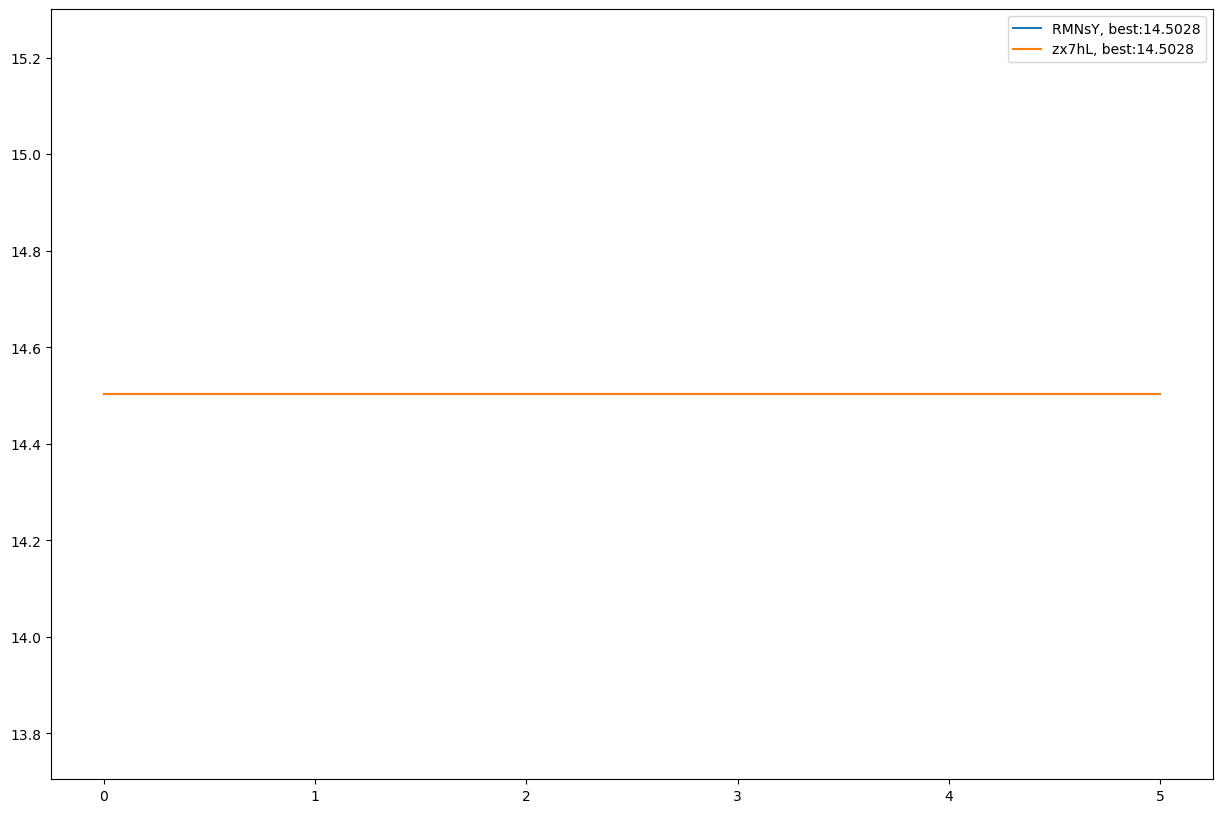

+---------------+------------+-----------------+--------------+----------+----------------+---------+
| Trials Name   |   treshold |   voltage_decay |   batch_size |       lr |   graded_spike |   Score |
+===============+============+=================+==============+==========+================+=========+
| RMNsY         |        3   |            0.85 |           80 | 0.000315 |              0 | 14.5028 |
+---------------+------------+-----------------+--------------+----------+----------------+---------+
| zx7hL         |        2.6 |            0.3  |           64 | 0.000105 |              0 | 14.5028 |
+---------------+------------+-----------------+--------------+----------+----------------+---------+
experiment codename u1cws9x3
/home/franzhd/lava-dl_exp/nni_experiments/dense_lif_1/results/u1cws9x3/db/nni.sqlite
[('OwbiJ', 0, '"27.486187845303867"'), ('OwbiJ', 1, '"29.820441988950275"'), ('OwbiJ', 2, '"31.477900552486187"'), ('OwbiJ', 3, '"32.04419889502763"'), ('OwbiJ', 4, '"32.47

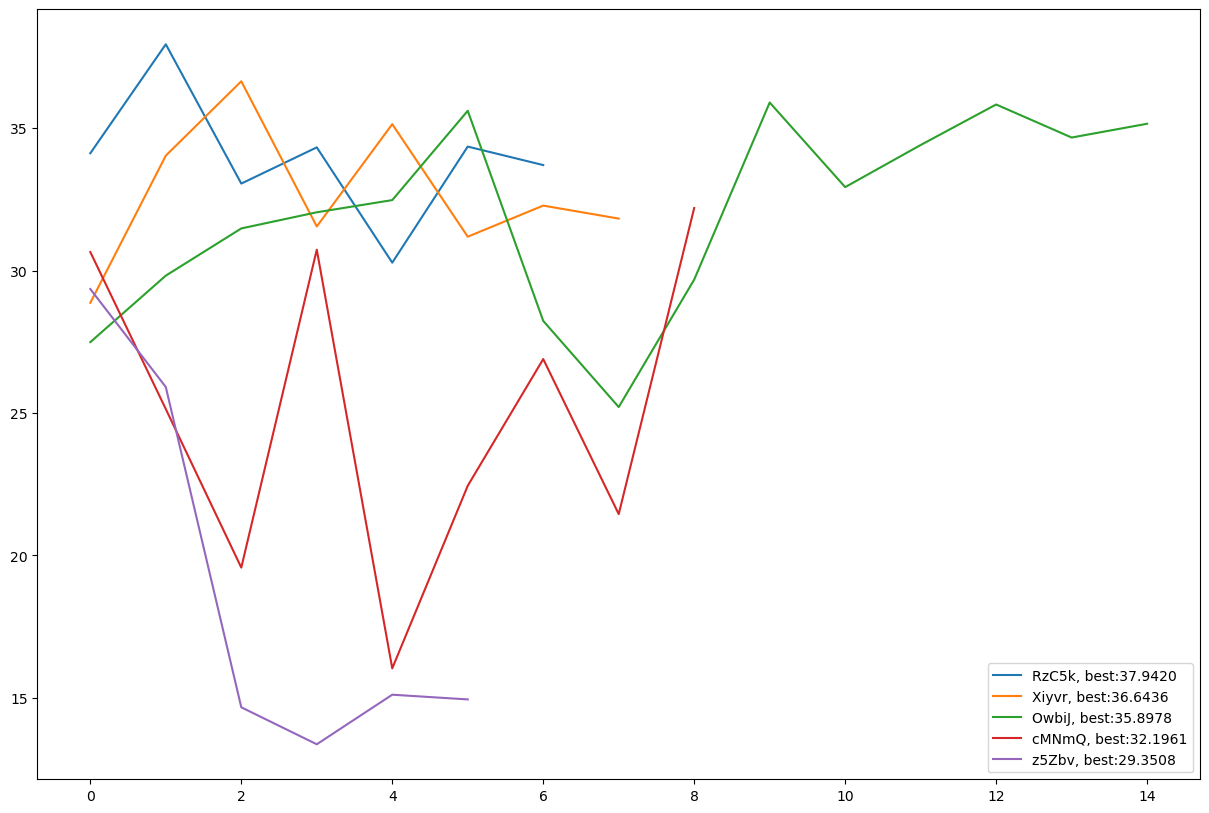

+---------------+------------+-----------------+--------------+----------+----------------+---------+
| Trials Name   |   treshold |   voltage_decay |   batch_size |       lr |   graded_spike |   Score |
+===============+============+=================+==============+==========+================+=========+
| RzC5k         |      0.255 |            0.7  |          256 | 0.000375 |              1 | 37.942  |
+---------------+------------+-----------------+--------------+----------+----------------+---------+
| Xiyvr         |      0.48  |            0.65 |          144 | 0.000155 |              0 | 36.6436 |
+---------------+------------+-----------------+--------------+----------+----------------+---------+
| OwbiJ         |      0.48  |            0.55 |          240 | 0.000265 |              1 | 35.8978 |
+---------------+------------+-----------------+--------------+----------+----------------+---------+
| cMNmQ         |      0.435 |            0.9  |           32 | 0.00058  |        

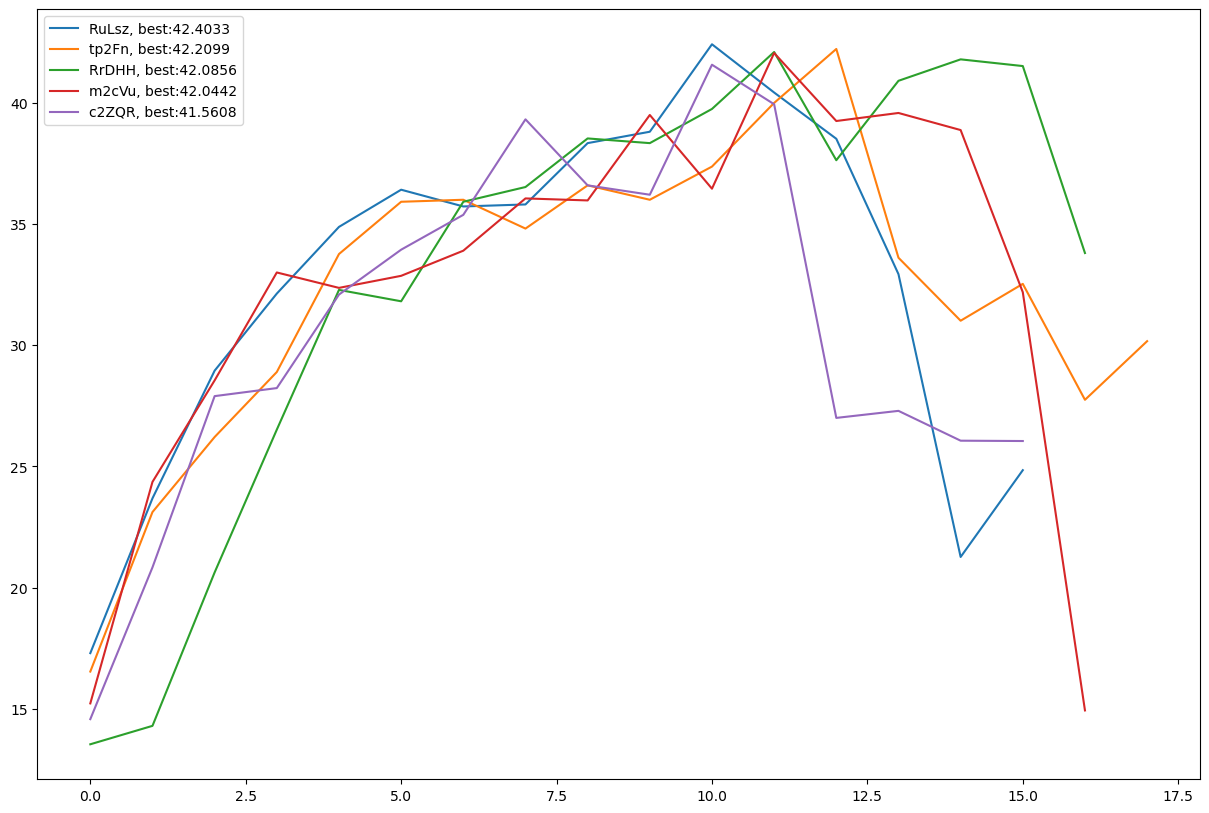

+---------------+------------+-----------------+--------------+----------+----------------+---------+
| Trials Name   |   treshold |   voltage_decay |   batch_size |       lr |   graded_spike |   Score |
+===============+============+=================+==============+==========+================+=========+
| RuLsz         |      0.285 |            0.65 |          208 | 0.00023  |              0 | 42.4033 |
+---------------+------------+-----------------+--------------+----------+----------------+---------+
| tp2Fn         |      0.3   |            0.6  |          224 | 0.000245 |              0 | 42.2099 |
+---------------+------------+-----------------+--------------+----------+----------------+---------+
| RrDHH         |      0.335 |            0.7  |          224 | 0.000195 |              0 | 42.0856 |
+---------------+------------+-----------------+--------------+----------+----------------+---------+
| m2cVu         |      0.305 |            0.6  |          224 | 0.00027  |        

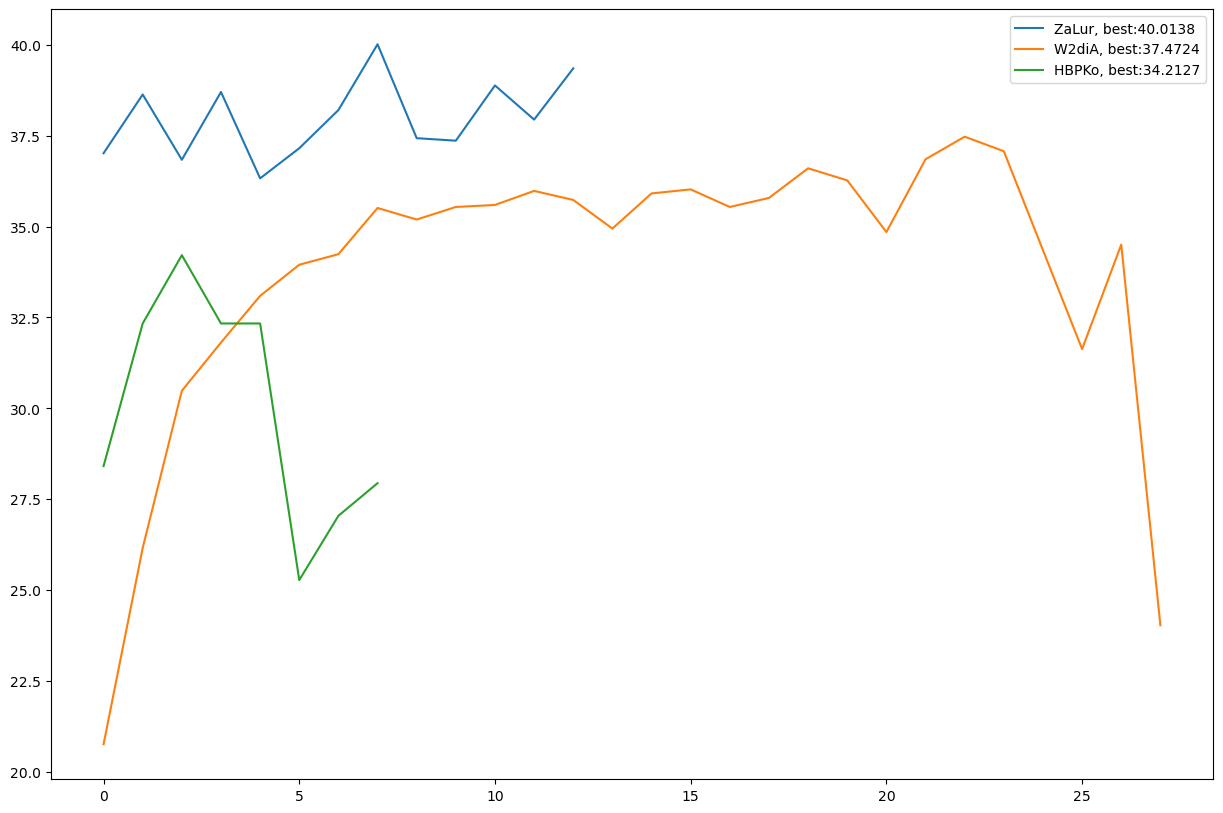

+---------------+------------+-----------------+--------------+----------+----------------+---------+
| Trials Name   |   treshold |   voltage_decay |   batch_size |       lr |   graded_spike |   Score |
+===============+============+=================+==============+==========+================+=========+
| ZaLur         |      0.69  |             0.2 |          176 | 0.000995 |              0 | 40.0138 |
+---------------+------------+-----------------+--------------+----------+----------------+---------+
| W2diA         |      0.815 |             0.2 |          224 | 0.000175 |              1 | 37.4724 |
+---------------+------------+-----------------+--------------+----------+----------------+---------+
| HBPKo         |      0.385 |             0   |           80 | 0.000455 |              0 | 34.2127 |
+---------------+------------+-----------------+--------------+----------+----------------+---------+
experiment codename jhb0xkv1
/home/franzhd/lava-dl_exp/nni_experiments/dense_lif_1

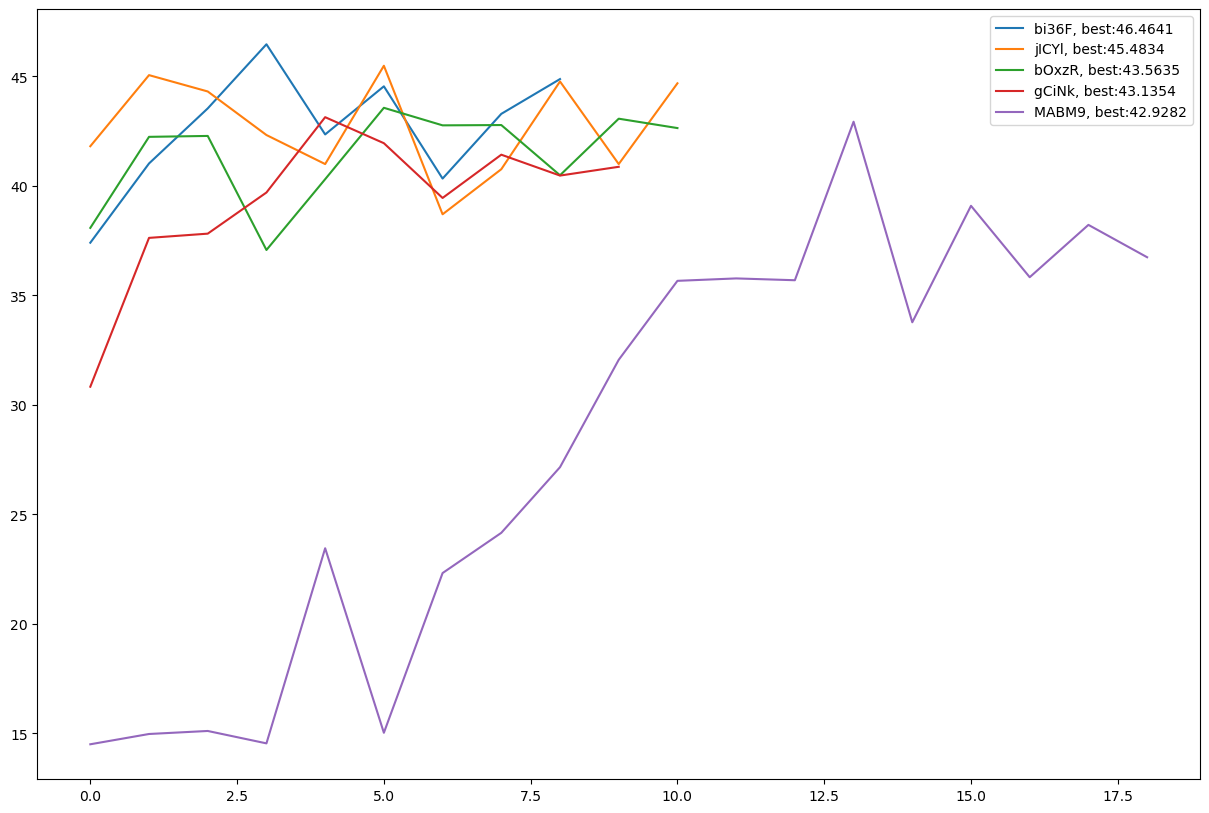

+---------------+------------+-----------------+--------------+----------+----------------+---------+
| Trials Name   |   treshold |   voltage_decay |   batch_size |       lr |   graded_spike |   Score |
+===============+============+=================+==============+==========+================+=========+
| bi36F         |      0.475 |            0.6  |          144 | 0.000485 |              0 | 46.4641 |
+---------------+------------+-----------------+--------------+----------+----------------+---------+
| jICYl         |      0.435 |            0.7  |           96 | 0.000675 |              0 | 45.4834 |
+---------------+------------+-----------------+--------------+----------+----------------+---------+
| bOxzR         |      0.445 |            0.55 |           64 | 0.00051  |              0 | 43.5635 |
+---------------+------------+-----------------+--------------+----------+----------------+---------+
| gCiNk         |      0.5   |            0.65 |          160 | 0.000325 |        

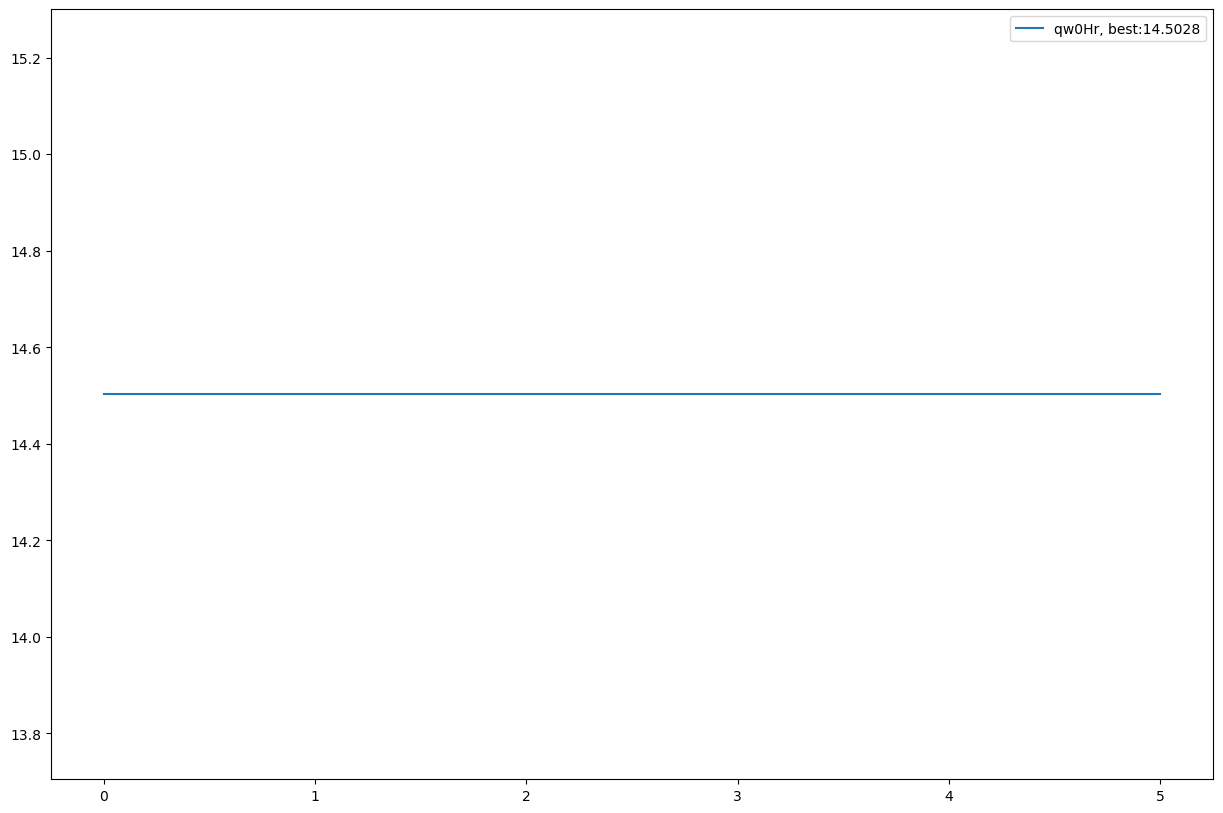

+---------------+------------+-----------------+--------------+---------+----------------+---------+
| Trials Name   |   treshold |   voltage_decay |   batch_size |      lr |   graded_spike |   Score |
+===============+============+=================+==============+=========+================+=========+
| qw0Hr         |       18.5 |             0.3 |          112 | 0.00028 |              0 | 14.5028 |
+---------------+------------+-----------------+--------------+---------+----------------+---------+
experiment codename 6wd0vzne
/home/franzhd/lava-dl_exp/nni_experiments/dense_lif_1/results/6wd0vzne/db/nni.sqlite
[('CPj9B', 0, '"23.853591160220994"'), ('CPj9B', 1, '"14.502762430939226"'), ('CPj9B', 2, '"14.502762430939226"'), ('CPj9B', 3, '"14.502762430939226"'), ('CPj9B', 4, '"14.502762430939226"'), ('CPj9B', 5, '"14.502762430939226"')]
found single Score


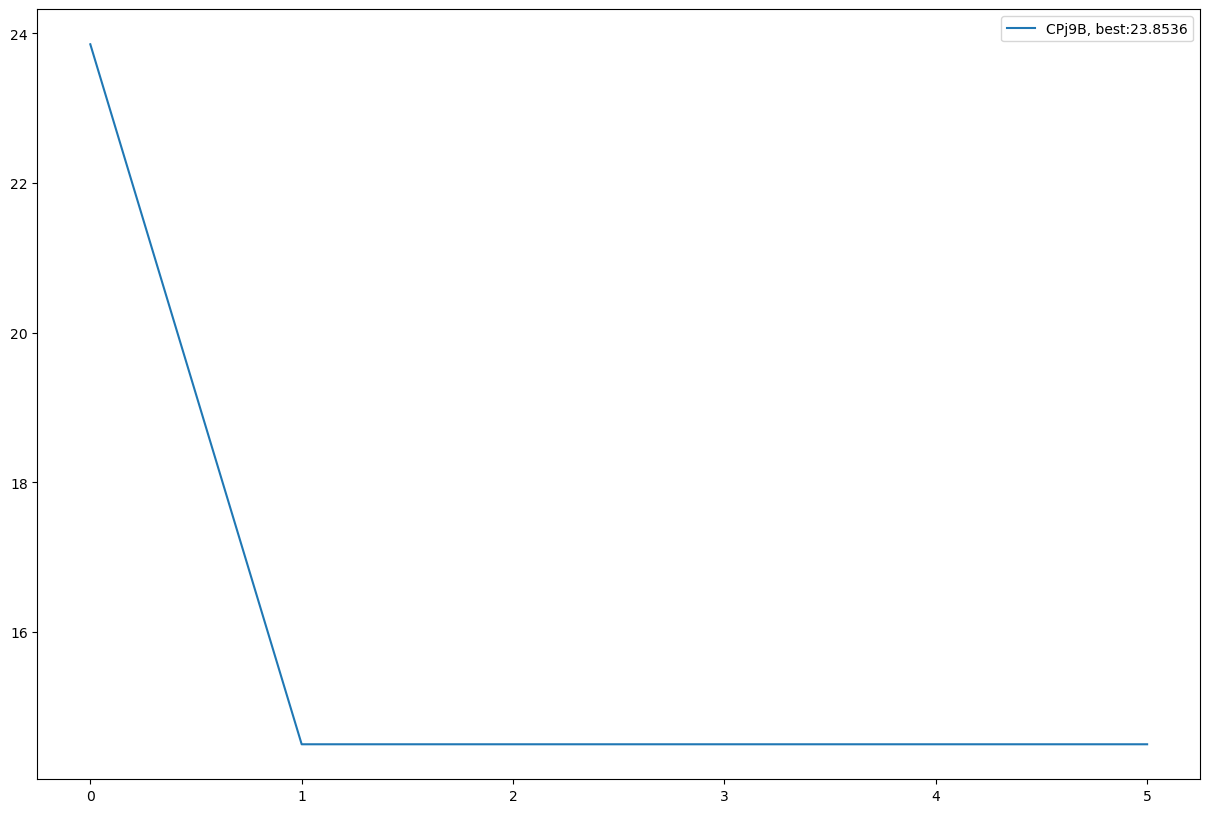

+---------------+------------+-----------------+--------------+---------+----------------+---------+
| Trials Name   |   treshold |   voltage_decay |   batch_size |      lr |   graded_spike |   Score |
+===============+============+=================+==============+=========+================+=========+
| CPj9B         |       0.02 |             0.6 |          224 | 0.00068 |              1 | 23.8536 |
+---------------+------------+-----------------+--------------+---------+----------------+---------+
experiment codename _latest
/home/franzhd/lava-dl_exp/nni_experiments/dense_lif_1/results/_latest/db/nni.sqlite
[('RrDHH', 0, '"13.549723756906076"'), ('RrDHH', 1, '"14.309392265193372"'), ('RrDHH', 2, '"20.6353591160221"'), ('RrDHH', 3, '"26.519337016574585"'), ('RrDHH', 4, '"32.27900552486187"'), ('RrDHH', 5, '"31.80939226519337"'), ('RrDHH', 6, '"35.91160220994475"'), ('RrDHH', 7, '"36.51933701657459"'), ('RrDHH', 8, '"38.52209944751381"'), ('RrDHH', 9, '"38.328729281767956"'), ('RrDHH',

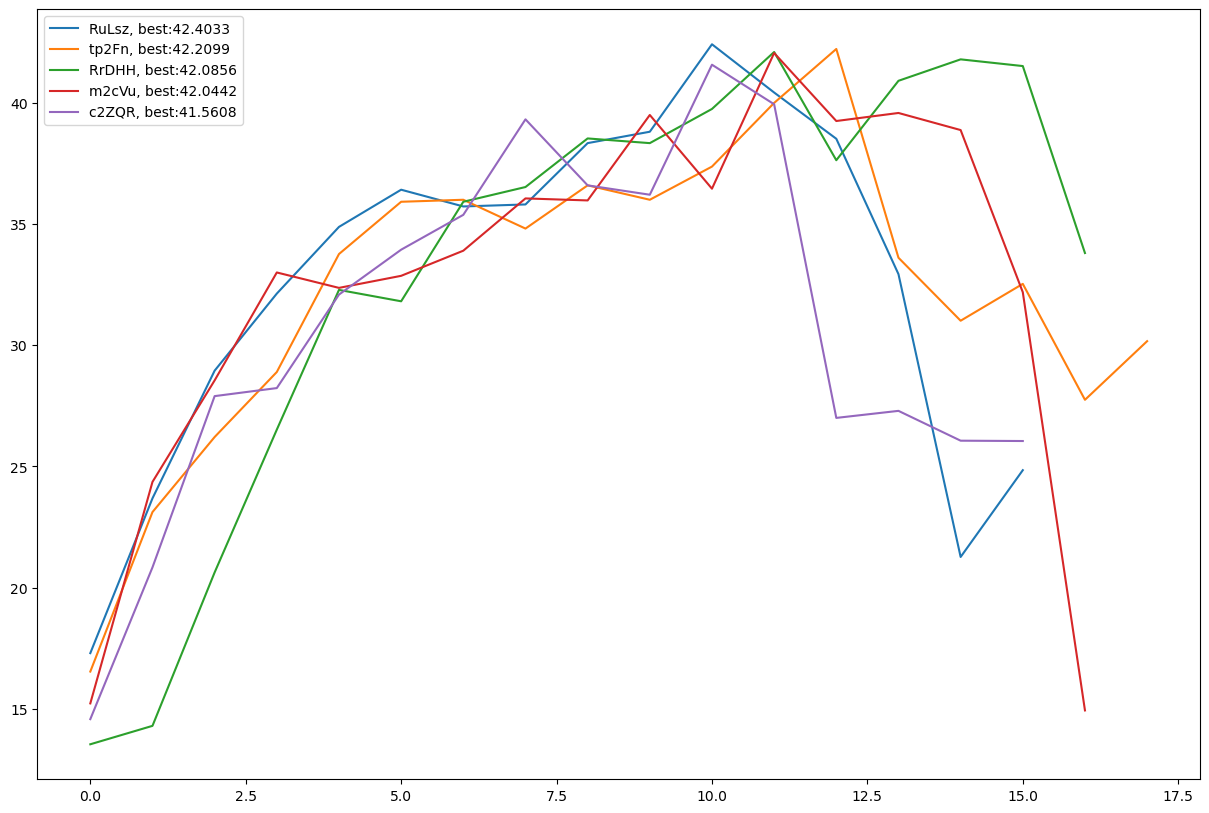

+---------------+------------+-----------------+--------------+----------+----------------+---------+
| Trials Name   |   treshold |   voltage_decay |   batch_size |       lr |   graded_spike |   Score |
+===============+============+=================+==============+==========+================+=========+
| RuLsz         |      0.285 |            0.65 |          208 | 0.00023  |              0 | 42.4033 |
+---------------+------------+-----------------+--------------+----------+----------------+---------+
| tp2Fn         |      0.3   |            0.6  |          224 | 0.000245 |              0 | 42.2099 |
+---------------+------------+-----------------+--------------+----------+----------------+---------+
| RrDHH         |      0.335 |            0.7  |          224 | 0.000195 |              0 | 42.0856 |
+---------------+------------+-----------------+--------------+----------+----------------+---------+
| m2cVu         |      0.305 |            0.6  |          224 | 0.00027  |        

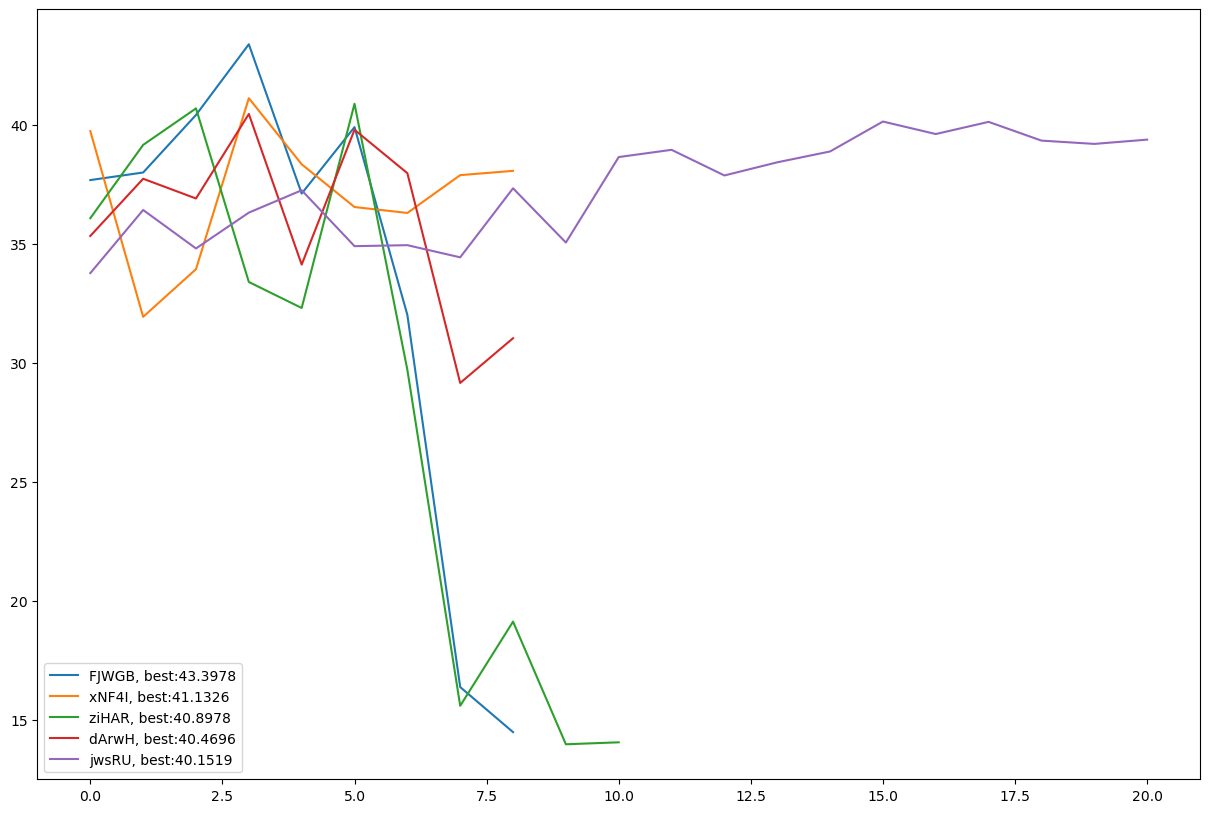

+---------------+------------+-----------------+--------------+----------+----------------+---------+
| Trials Name   |   treshold |   voltage_decay |   batch_size |       lr |   graded_spike |   Score |
+===============+============+=================+==============+==========+================+=========+
| FJWGB         |      0.25  |            0.85 |           96 | 0.00081  |              1 | 43.3978 |
+---------------+------------+-----------------+--------------+----------+----------------+---------+
| xNF4I         |      0.415 |            0.75 |           80 | 0.000595 |              1 | 41.1326 |
+---------------+------------+-----------------+--------------+----------+----------------+---------+
| ziHAR         |      0.27  |            0.75 |           64 | 0.00055  |              1 | 40.8978 |
+---------------+------------+-----------------+--------------+----------+----------------+---------+
| dArwH         |      0.495 |            0.65 |           32 | 0.000795 |        

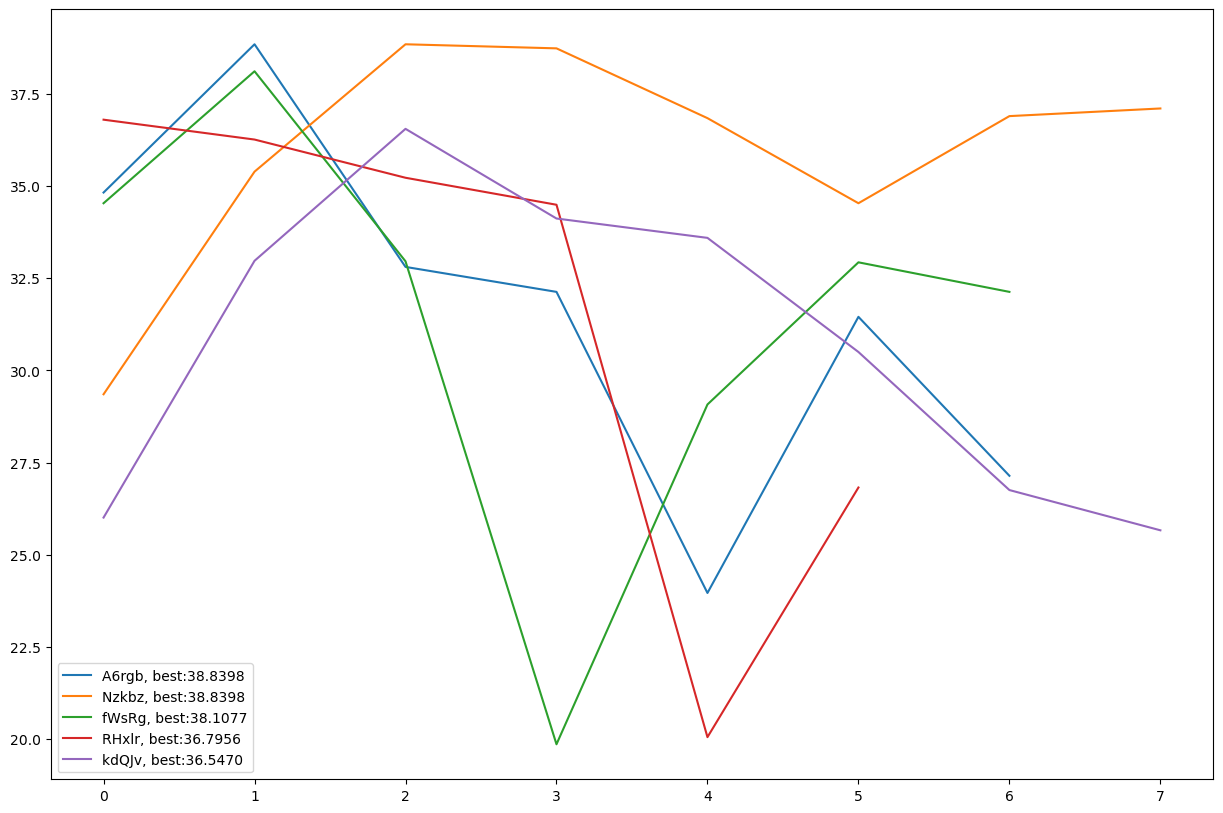

+---------------+------------+-----------------+--------------+----------+----------------+---------+
| Trials Name   |   treshold |   voltage_decay |   batch_size |       lr |   graded_spike |   Score |
+===============+============+=================+==============+==========+================+=========+
| A6rgb         |      0.57  |            0.65 |          192 | 0.000635 |              0 | 38.8398 |
+---------------+------------+-----------------+--------------+----------+----------------+---------+
| Nzkbz         |      0.845 |            0.4  |          224 | 0.000635 |              0 | 38.8398 |
+---------------+------------+-----------------+--------------+----------+----------------+---------+
| fWsRg         |      0.48  |            0.5  |          176 | 0.00071  |              0 | 38.1077 |
+---------------+------------+-----------------+--------------+----------+----------------+---------+
| RHxlr         |      0.505 |            0.75 |          256 | 0.000815 |        

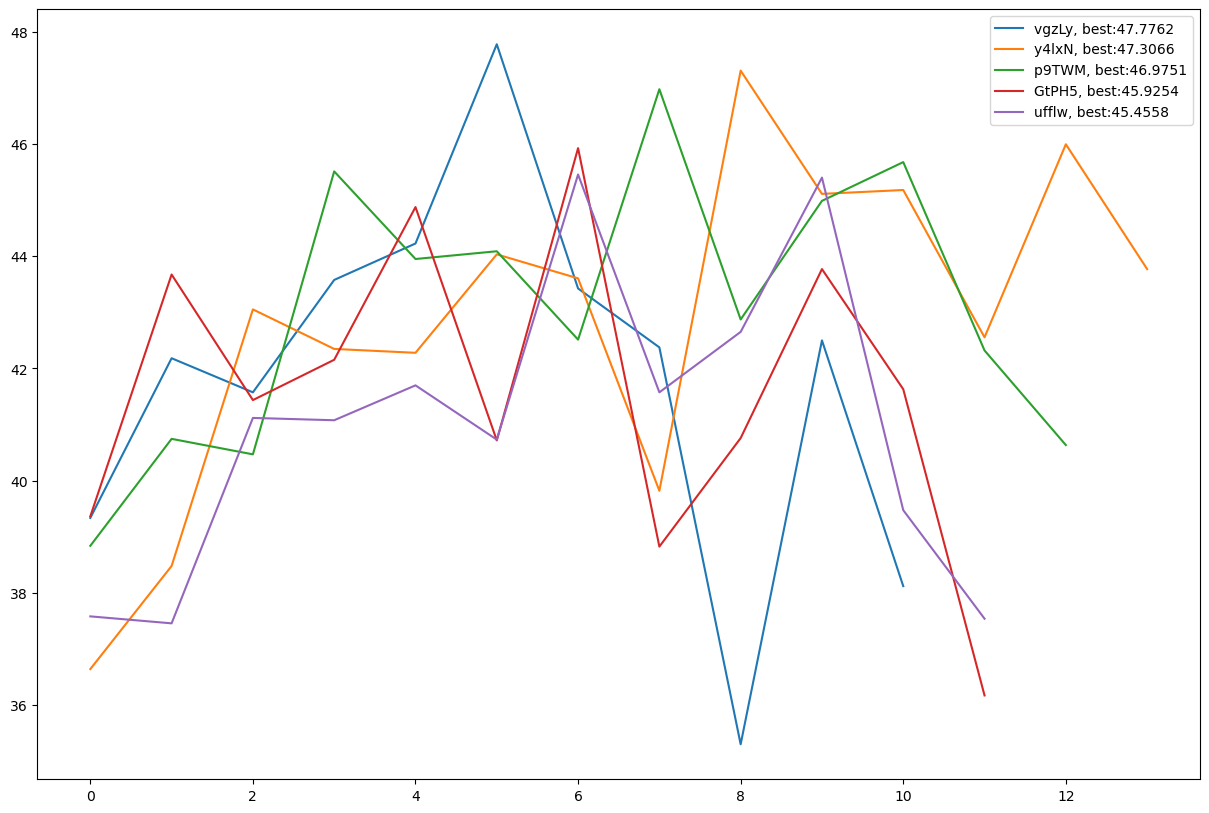

+---------------+------------+-----------------+--------------+----------+----------------+---------+
| Trials Name   |   treshold |   voltage_decay |   batch_size |       lr |   graded_spike |   Score |
+===============+============+=================+==============+==========+================+=========+
| vgzLy         |      0.38  |            0.7  |          160 | 0.000655 |              0 | 47.7762 |
+---------------+------------+-----------------+--------------+----------+----------------+---------+
| y4lxN         |      0.43  |            0.65 |          160 | 0.000705 |              0 | 47.3066 |
+---------------+------------+-----------------+--------------+----------+----------------+---------+
| p9TWM         |      0.4   |            0.7  |          176 | 0.000665 |              0 | 46.9751 |
+---------------+------------+-----------------+--------------+----------+----------------+---------+
| GtPH5         |      0.365 |            0.7  |          160 | 0.00068  |        

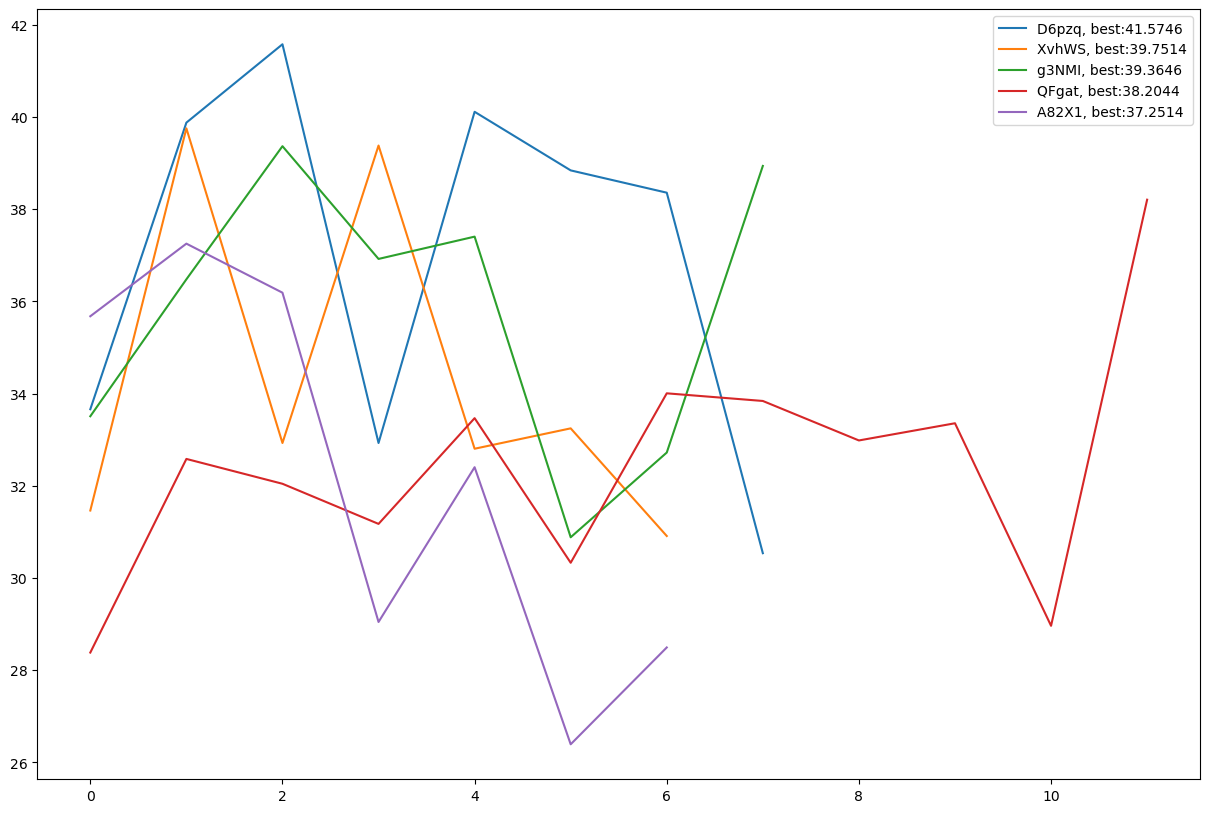

+---------------+------------+-----------------+--------------+----------+----------------+---------+
| Trials Name   |   treshold |   voltage_decay |   batch_size |       lr |   graded_spike |   Score |
+===============+============+=================+==============+==========+================+=========+
| D6pzq         |      0.45  |            0.55 |          160 | 0.0006   |              0 | 41.5746 |
+---------------+------------+-----------------+--------------+----------+----------------+---------+
| XvhWS         |      0.635 |            0.65 |          176 | 0.000705 |              0 | 39.7514 |
+---------------+------------+-----------------+--------------+----------+----------------+---------+
| g3NMI         |      0.42  |            0.5  |          240 | 0.0006   |              0 | 39.3646 |
+---------------+------------+-----------------+--------------+----------+----------------+---------+
| QFgat         |      0.26  |            0.75 |          240 | 0.000165 |        

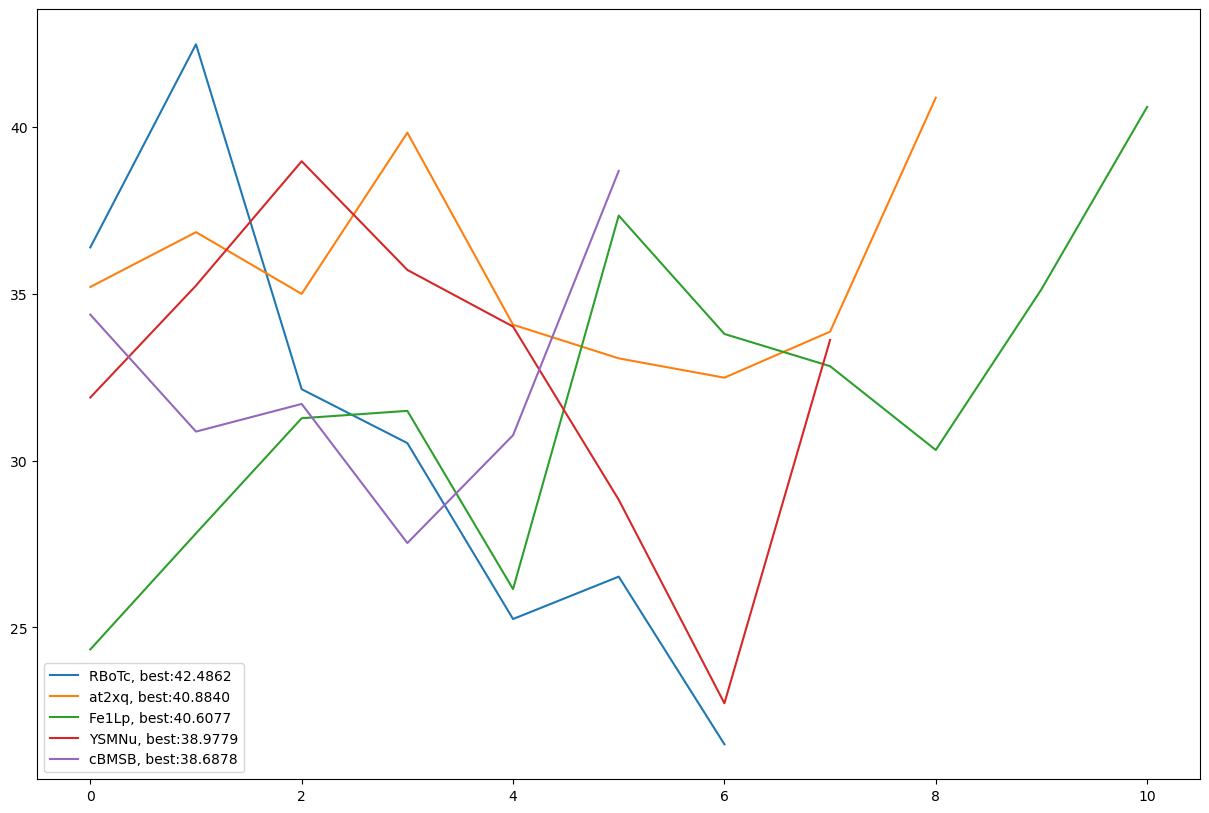

+---------------+------------+-----------------+--------------+----------+----------------+---------+
| Trials Name   |   treshold |   voltage_decay |   batch_size |       lr |   graded_spike |   Score |
+===============+============+=================+==============+==========+================+=========+
| RBoTc         |      0.23  |            1    |          160 | 0.00042  |              1 | 42.4862 |
+---------------+------------+-----------------+--------------+----------+----------------+---------+
| at2xq         |      0.31  |            0.65 |          208 | 0.000325 |              1 | 40.884  |
+---------------+------------+-----------------+--------------+----------+----------------+---------+
| Fe1Lp         |      0.335 |            0.8  |          176 | 0.000365 |              1 | 40.6077 |
+---------------+------------+-----------------+--------------+----------+----------------+---------+
| YSMNu         |      0.32  |            0.55 |          176 | 0.000525 |        

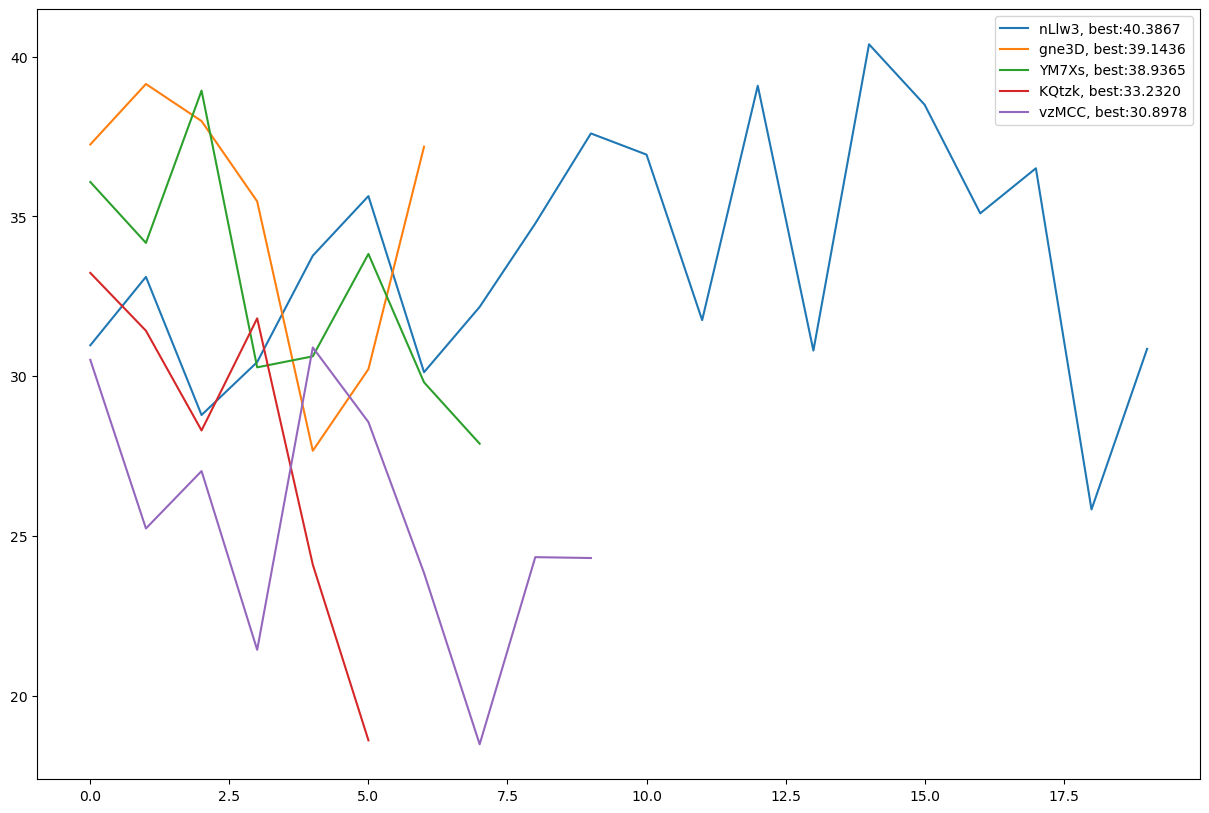

+---------------+------------+-----------------+--------------+----------+----------------+---------+
| Trials Name   |   treshold |   voltage_decay |   batch_size |       lr |   graded_spike |   Score |
+===============+============+=================+==============+==========+================+=========+
| nLlw3         |      0.385 |            0.45 |           80 | 0.00012  |              1 | 40.3867 |
+---------------+------------+-----------------+--------------+----------+----------------+---------+
| gne3D         |      0.625 |            0.5  |          112 | 0.000605 |              0 | 39.1436 |
+---------------+------------+-----------------+--------------+----------+----------------+---------+
| YM7Xs         |      0.525 |            0.25 |          176 | 0.00056  |              0 | 38.9365 |
+---------------+------------+-----------------+--------------+----------+----------------+---------+
| KQtzk         |      0.71  |            0.9  |          144 | 0.000325 |        

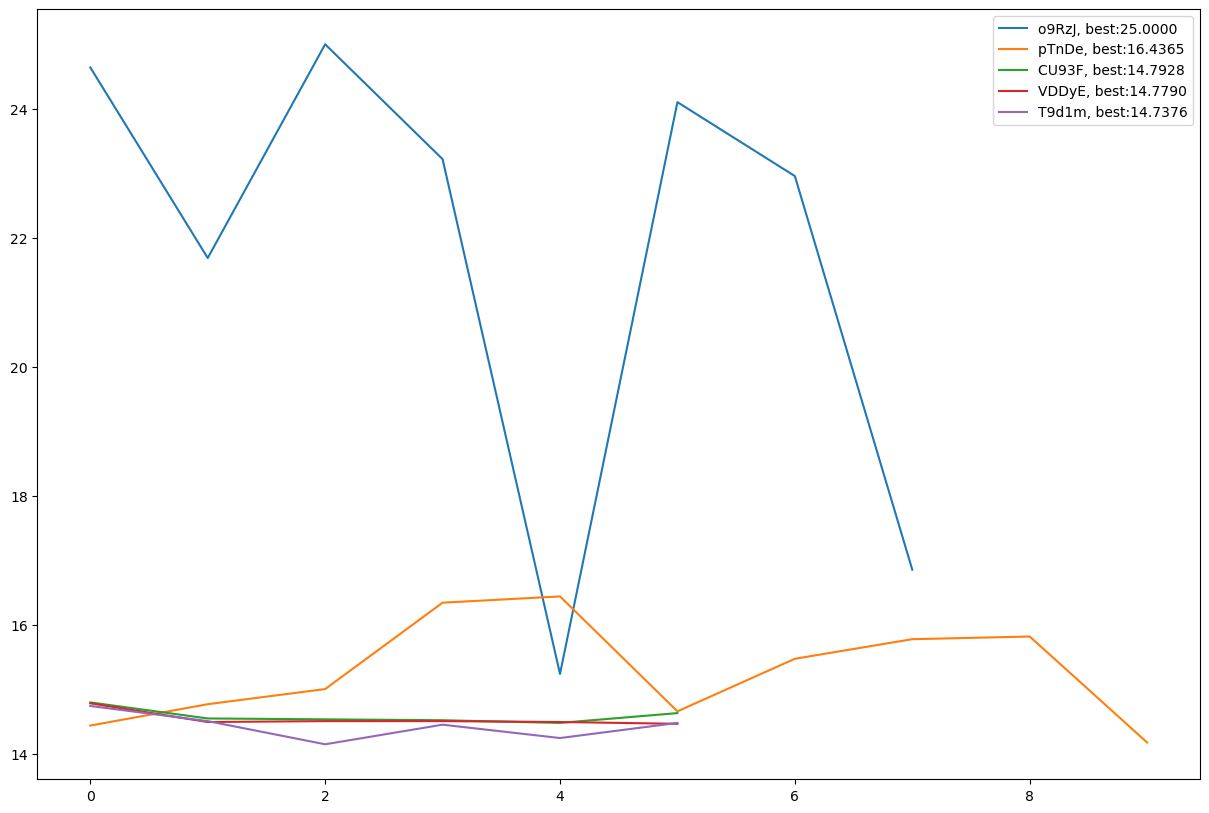

+---------------+------------+-----------------+--------------+----------+----------------+---------+
| Trials Name   |   treshold |   voltage_decay |   batch_size |       lr |   graded_spike |   Score |
+===============+============+=================+==============+==========+================+=========+
| o9RzJ         |        1   |            0.4  |           96 | 0.00088  |              1 | 25      |
+---------------+------------+-----------------+--------------+----------+----------------+---------+
| pTnDe         |        5.5 |            0.2  |          128 | 0.00087  |              1 | 16.4365 |
+---------------+------------+-----------------+--------------+----------+----------------+---------+
| CU93F         |       11   |            0.15 |          144 | 0.00088  |              1 | 14.7928 |
+---------------+------------+-----------------+--------------+----------+----------------+---------+
| VDDyE         |        8   |            0.35 |          128 | 0.000745 |        

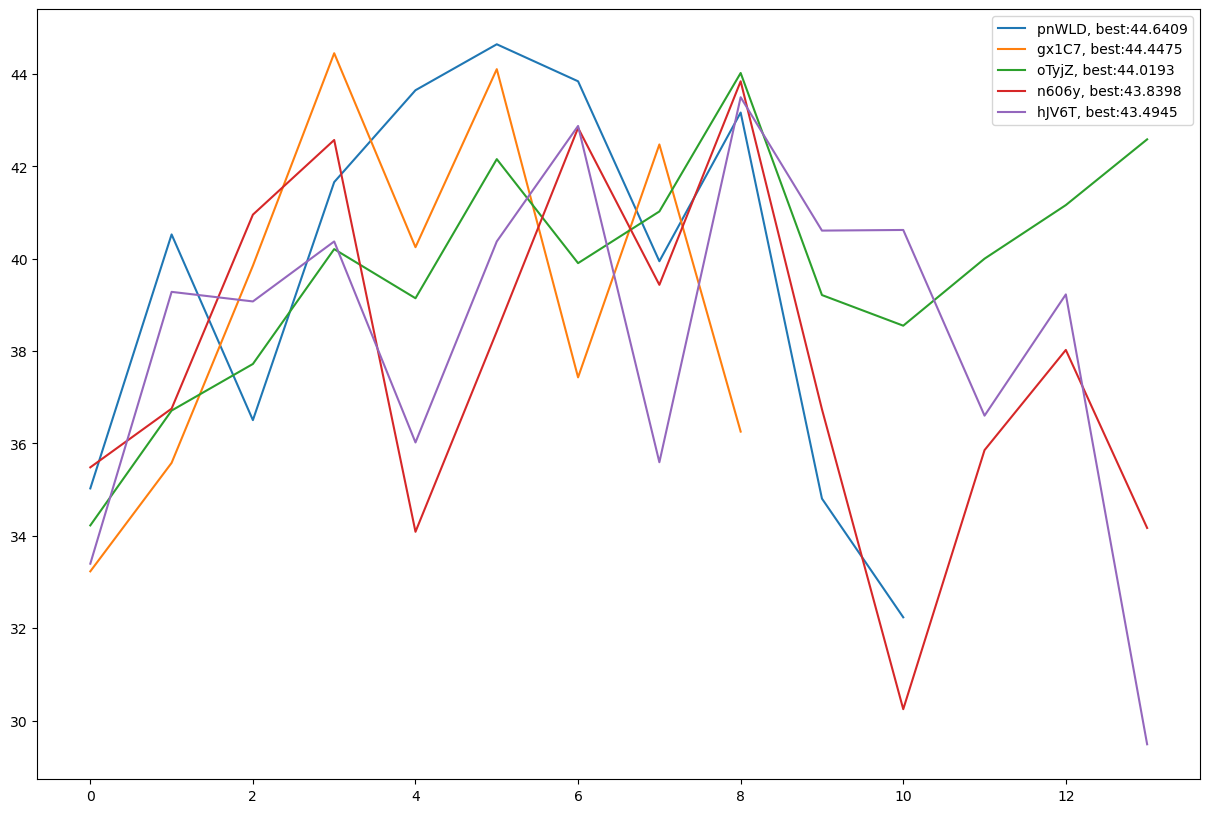

+---------------+------------+-----------------+--------------+----------+----------------+---------+
| Trials Name   |   treshold |   voltage_decay |   batch_size |       lr |   graded_spike |   Score |
+===============+============+=================+==============+==========+================+=========+
| pnWLD         |      0.31  |            0.65 |          192 | 0.00055  |              0 | 44.6409 |
+---------------+------------+-----------------+--------------+----------+----------------+---------+
| gx1C7         |      0.32  |            0.7  |          208 | 0.00052  |              0 | 44.4475 |
+---------------+------------+-----------------+--------------+----------+----------------+---------+
| oTyjZ         |      0.455 |            0.65 |          208 | 0.000535 |              0 | 44.0193 |
+---------------+------------+-----------------+--------------+----------+----------------+---------+
| n606y         |      0.385 |            0.7  |          208 | 0.000605 |        

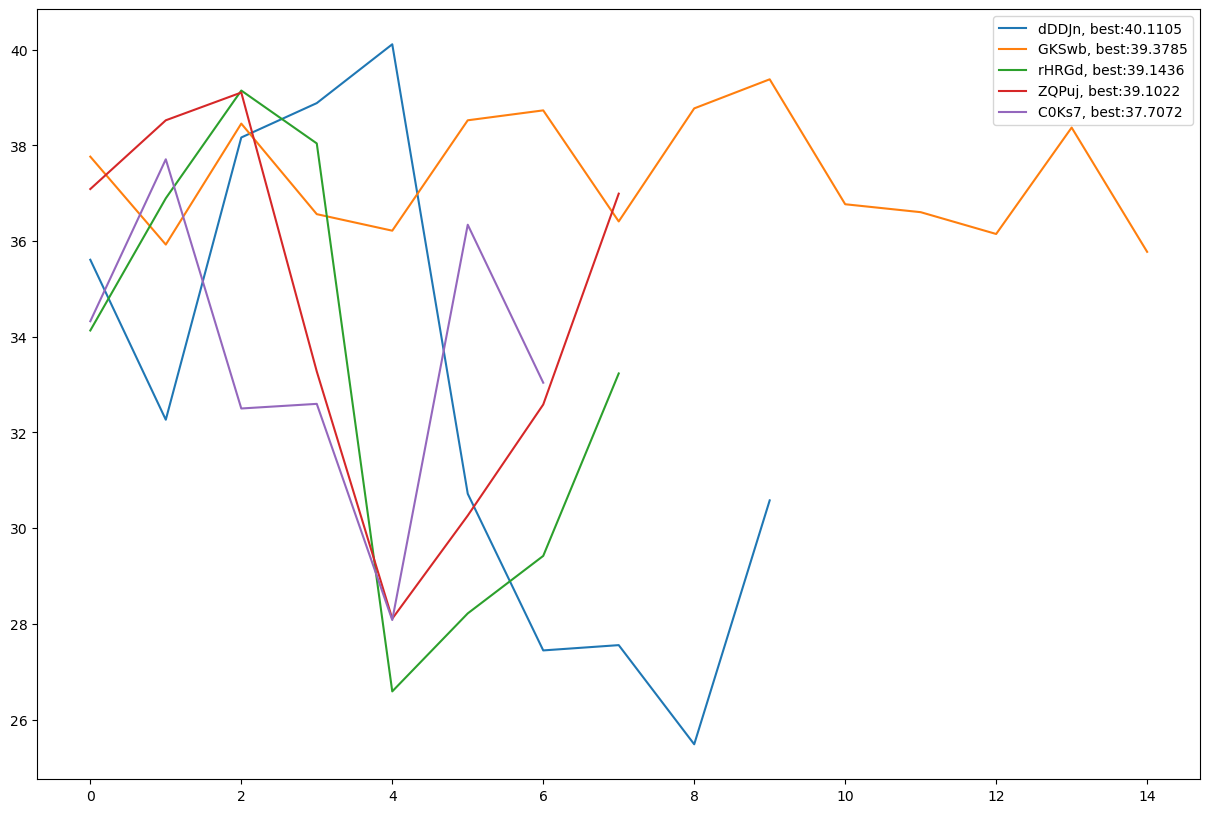

+---------------+------------+-----------------+--------------+----------+----------------+---------+
| Trials Name   |   treshold |   voltage_decay |   batch_size |       lr |   graded_spike |   Score |
+===============+============+=================+==============+==========+================+=========+
| dDDJn         |      0.155 |            0.3  |          208 | 0.000435 |              1 | 40.1105 |
+---------------+------------+-----------------+--------------+----------+----------------+---------+
| GKSwb         |      0.57  |            0.25 |          160 | 0.00021  |              1 | 39.3785 |
+---------------+------------+-----------------+--------------+----------+----------------+---------+
| rHRGd         |      0.175 |            0.35 |          144 | 0.00045  |              1 | 39.1436 |
+---------------+------------+-----------------+--------------+----------+----------------+---------+
| ZQPuj         |      0.655 |            0.65 |          144 | 0.000385 |        

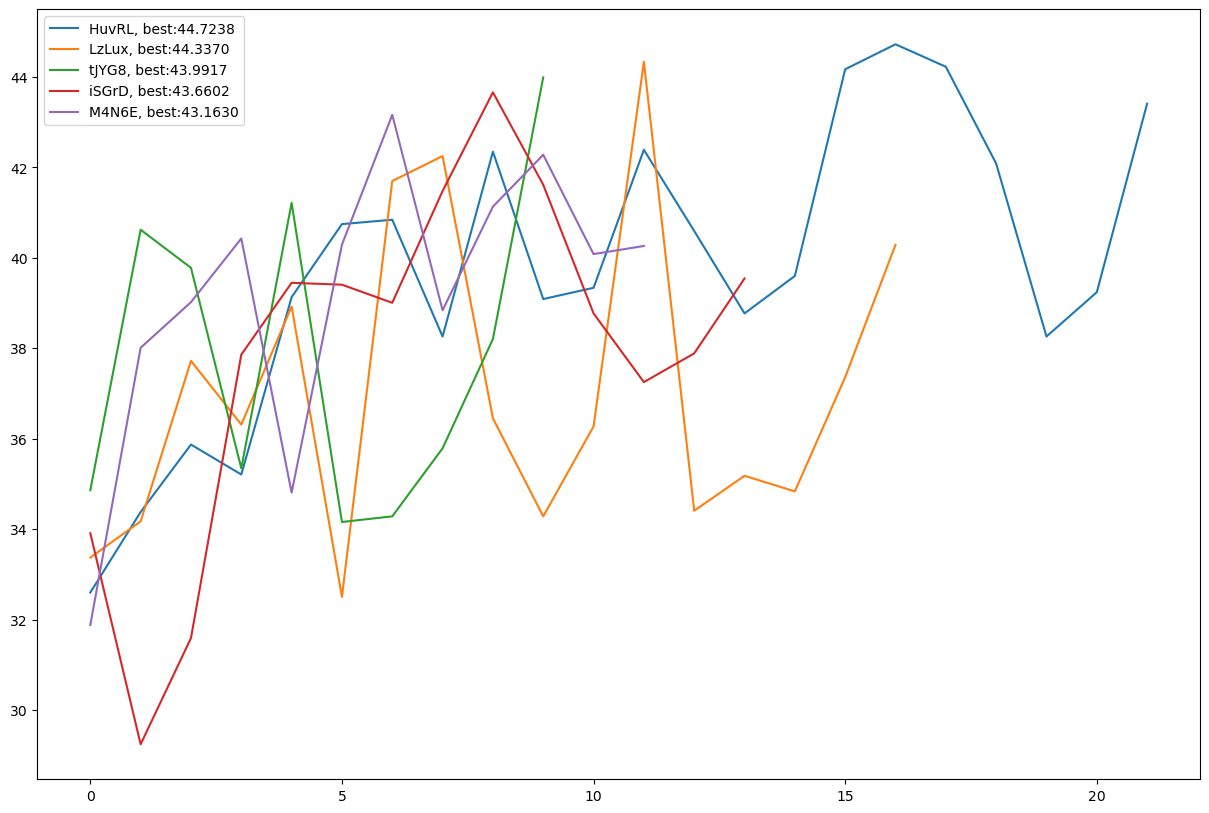

+---------------+------------+-----------------+--------------+----------+----------------+---------+
| Trials Name   |   treshold |   voltage_decay |   batch_size |       lr |   graded_spike |   Score |
+===============+============+=================+==============+==========+================+=========+
| HuvRL         |      0.29  |            0.4  |          176 | 0.00067  |              0 | 44.7238 |
+---------------+------------+-----------------+--------------+----------+----------------+---------+
| LzLux         |      0.25  |            0.3  |          192 | 0.000645 |              0 | 44.337  |
+---------------+------------+-----------------+--------------+----------+----------------+---------+
| tJYG8         |      0.23  |            0.35 |          192 | 0.000705 |              0 | 43.9917 |
+---------------+------------+-----------------+--------------+----------+----------------+---------+
| iSGrD         |      0.235 |            0.3  |          192 | 0.00069  |        

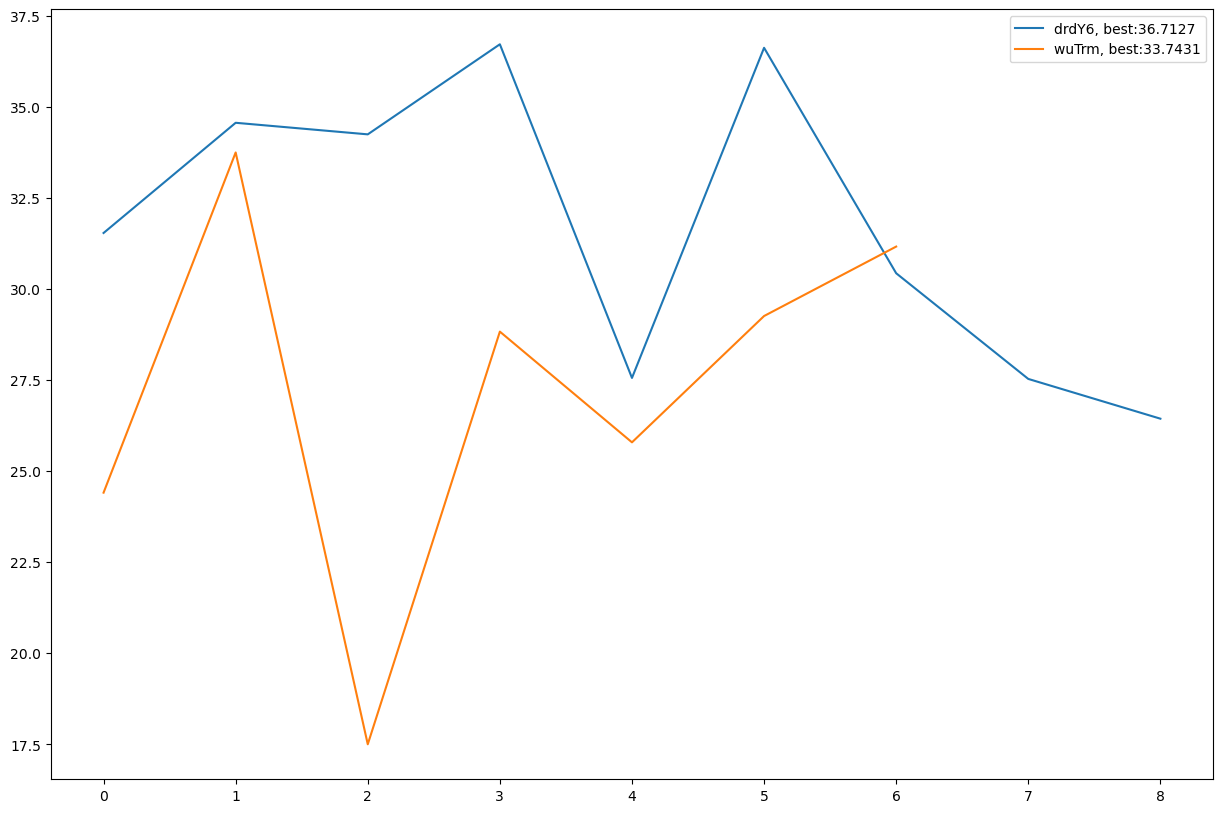

+---------------+------------+-----------------+--------------+----------+----------------+---------+
| Trials Name   |   treshold |   voltage_decay |   batch_size |       lr |   graded_spike |   Score |
+===============+============+=================+==============+==========+================+=========+
| drdY6         |      0.245 |            0.25 |          256 | 0.000435 |              0 | 36.7127 |
+---------------+------------+-----------------+--------------+----------+----------------+---------+
| wuTrm         |      0.82  |            0.9  |          128 | 0.000905 |              1 | 33.7431 |
+---------------+------------+-----------------+--------------+----------+----------------+---------+
experiment codename tbyj83gz
no database file found in the experiment gfolder 



In [4]:
show_results(path)

[1 4 0 0 0 2 5 1 4 5 3 3 5 5 4 0 3 5 5 5 1 0 5 3 4 1 4 2 0 0 4 5 2 2 3 4 1
 5 2 3 0 0 1 2 0 5 5 2 2 1]
[4 4 6 6 3 0 1 0 1 3 6 5 5 4 2 4 0 5 6 6 6 0 1 3 6 3 5 0 0 2 4 0 5 1 3 1 4
 4 2 4 2 5 6 3 5 1 4 0 2 0]


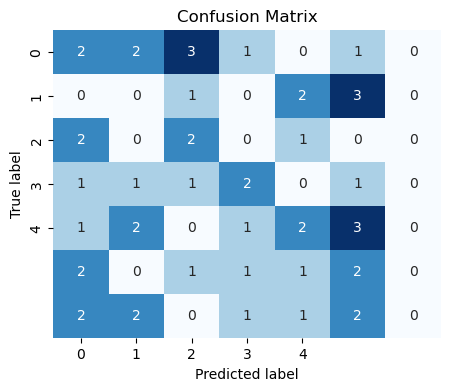

In [5]:
import os
import sys
from typing import Any
import matplotlib.pyplot as plot
import numpy as np
import seaborn as sns 
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

def gen_confusion_matrix(predictions, labels):
    
    num_label = max(labels)
    conf_matrix = confusion_matrix(predictions, labels)
    # Plot confusion matrix using Seaborn
    plt.figure(figsize=(5, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=range(num_label),
                yticklabels=range(num_label))

    plt.title('Confusion Matrix')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')

    # Save the plot
    plt.show()

def custom_operation(matrix):
    # Sum the elements along the last dimension
    summed_matrix = np.sum(matrix, axis=-1)

    # Divide the sum by the number of elements in the second dimension
    divided_matrix = summed_matrix / matrix.shape[1]

    # Find the maximum value along the second dimension and its index
    max_values = np.max(divided_matrix, axis=1)
    max_indices = np.argmax(divided_matrix, axis=1)

    # Assign the index of the maximum value to the nth element
    result = np.concatenate([divided_matrix.flatten(), max_values.flatten()])
    result[-matrix.shape[0]:] = max_indices

    return max_indices

# Example usage:
n = 50  # Replace with your desired value for n
matrix = np.random.random((n, 7, 40))  # Replace this with your actual matrix
labels = np.random.randint(low=0, high=6, size=n)

result = custom_operation(matrix)
print(labels)
print(result)
gen_confusion_matrix(result, labels)
